In [44]:
import pandas as pd
import numpy as np
from gensim import corpora, models, similarities
import pickle
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from ast import literal_eval
import itertools

In [ ]:
dropbox = "/Users/mr/Dropbox/moviemeta/"

In [21]:
def iterdocs(filepath):
    for line in open (filepath):
        yield literal_eval(line)
            
class Corpus(object):    
    def __init__(self, filename):
        self.filepath = dropbox + filename
        self.dictionary = corpora.Dictionary(iterdocs(self.filepath))
        #filter out the words with very low and very high document frequency
        self.dictionary.filter_extremes(no_below=2, no_above=0.2) 
    def __iter__(self):
        for doc in iterdocs(self.filepath):
            yield self.dictionary.doc2bow(doc)

In [23]:
corpus = Corpus('imdb_plots_since_2014.list')
dictionary = corpus.dictionary

In [28]:
def plot_dfs(dictionary,top=True, num=20):
    words, counts = [],[]
    dfs = sorted(dictionary.dfs.items(), key=lambda x : x[1], reverse=True)
    if top == True:
        words = [dictionary[tup[0]] for tup in dfs[:num]]
        counts = [tup[1] for tup in dfs[:num]]
    else:
        words = [dictionary[tup[0]] for tup in dfs[-num:]]
        counts = [tup[1] for tup in dfs[-num:]]
    plt.figure(figsize=(20,10))
    plt.bar(range(num), counts, color=sns.color_palette()[0])
    plt.xticks(range(num),words)
    plt.show()

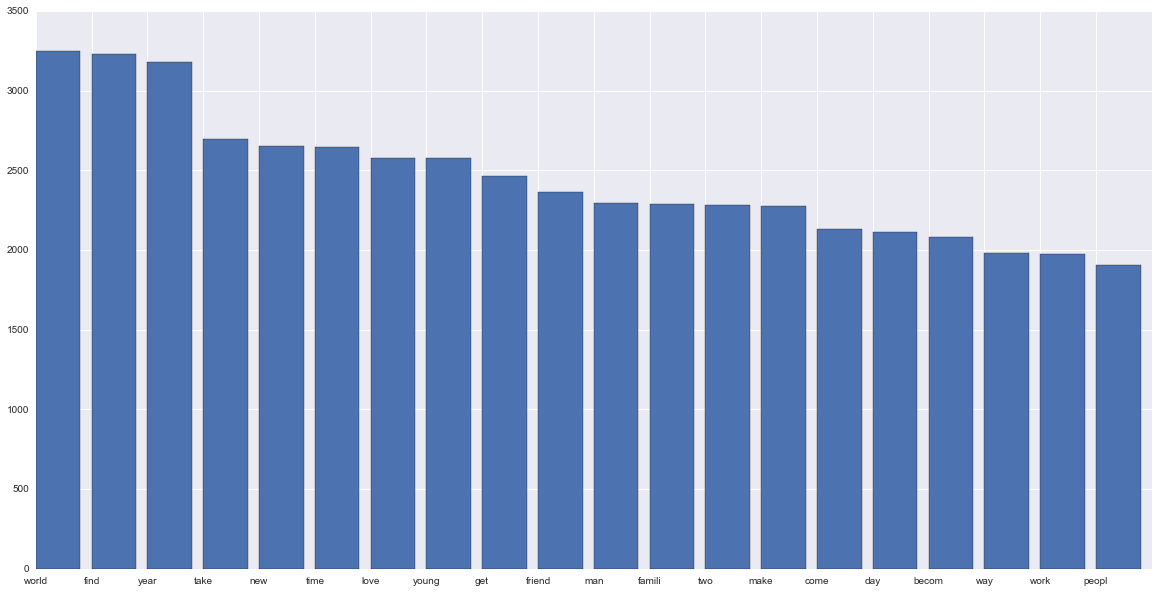

In [29]:
plot_dfs(dictionary)

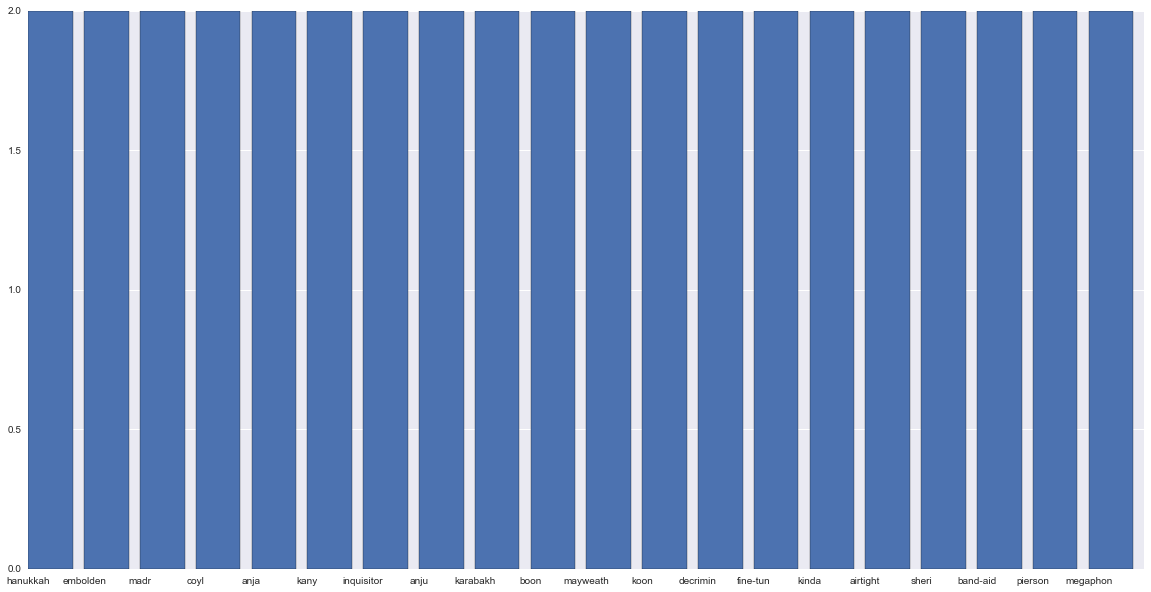

In [30]:
plot_dfs(dictionary,top=False)

In [31]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [32]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=20)
corpus_lsi = lsi[corpus_tfidf] 

In [34]:
lsi.print_topics(20)

[u'0.118*"love" + 0.112*"find" + 0.108*"famili" + 0.107*"world" + 0.103*"year" + 0.100*"man" + 0.099*"young" + 0.097*"friend" + 0.096*"get" + 0.096*"new"',
 u'-0.254*"music" + -0.200*"documentari" + -0.163*"artist" + -0.151*"art" + 0.133*"father" + -0.113*"explor" + -0.113*"world" + 0.111*"find" + 0.108*"mother" + 0.106*"friend"',
 u'0.300*"love" + 0.239*"music" + -0.177*"war" + -0.136*"murder" + 0.133*"relationship" + 0.124*"girl" + 0.119*"friend" + 0.118*"dream" + -0.114*"killer" + 0.114*"nt"',
 u'0.354*"father" + 0.351*"famili" + 0.206*"mother" + 0.186*"son" + -0.150*"get" + 0.144*"brother" + -0.144*"friend" + 0.141*"daughter" + -0.118*"night" + 0.110*"war"',
 u'-0.366*"love" + 0.291*"school" + 0.258*"music" + -0.208*"woman" + -0.189*"man" + 0.159*"famili" + 0.146*"high" + 0.146*"father" + 0.124*"year" + -0.121*"human"',
 u'-0.442*"music" + 0.359*"school" + 0.190*"high" + 0.177*"student" + -0.147*"man" + -0.139*"murder" + -0.117*"band" + -0.112*"killer" + 0.104*"girl" + -0.099*"arti

In [35]:
with open(dropbox +'imdb_movies_since_2014.pickle', 'rb') as f:
    movies = np.load(f)

In [36]:
corpus_list = list(corpus_lsi)

In [39]:
for i,doc in enumerate(corpus_list[:100]):
    doc.sort(key=lambda x: x[1],reverse=True)
    print doc[0]
    print movies[i]

(0, 0.16061102461433566)
#1 at the Apocalypse Box Office (2015)
(0, 0.17268601009671822)
#50Fathers (2015)
(0, 0.068062495818668758)
#BeRobin the Movie (2015)
(0, 0.13446121912399672)
#Beings (2015)
(0, 0.11967068420059443)
#Disneyland60 (2015)
(0, 0.063125350895318608)
#GirlCrush (2015)
(0, 0.13467794000926814)
#Horror (2015)
(0, 0.097092437980904278)
#Insocial (2015)
(0, 0.081245244908550146)
#Lucky Number (2015)
(0, 0.10458866717615081)
#O2LForever (2015)
(0, 0.14507322959655924)
#Roommates (2015)
(0, 0.051141776377536058)
#SaveHouston (2015)
(0, 0.19696882448751957)
#Single: Girl behind the camera (2015)
(0, 0.14543077606420277)
#Sohvr (2015) (VG)
(0, 0.10092612311426988)
#Speedball (2015)
(0, 0.12945619419639512)
#bff (2016)
(0, 0.1478502929245952)
#garotas: O Filme (2015)
(0, 0.10013508364036749)
#intimacy (2016)
(0, 0.072650301749953558)
$elfie Shootout (2016)
(0, 0.12312065751661042)
'79 Parts (2015)
(0, 0.11570119813091692)
'Merica, My Lovely (2015)
(0, 0.12377626940849668)
'N

In [40]:
lda = models.LdaModel(corpus,id2word=dictionary, num_topics=20)

In [48]:
lda.show_topics(20, 5)

[u'0.007*famili + 0.006*thoma + 0.004*day + 0.004*two + 0.004*meet',
 u'0.007*world + 0.006*dream + 0.006*jame + 0.005*documentari + 0.005*movi',
 u'0.010*investig + 0.009*murder + 0.008*mysteri + 0.008*town + 0.007*case',
 u'0.010*daniel + 0.007*zoe + 0.006*year + 0.006*sport + 0.006*becom',
 u'0.008*women + 0.005*write + 0.005*take + 0.004*friend + 0.004*time',
 u'0.007*world + 0.007*make + 0.006*man + 0.006*time + 0.005*becom',
 u'0.009*year + 0.007*new + 0.007*friend + 0.006*day + 0.006*man',
 u'0.016*world + 0.010*new + 0.007*human + 0.006*citi + 0.005*earth',
 u'0.009*love + 0.008*year + 0.007*world + 0.006*young + 0.006*famili',
 u'0.008*women + 0.008*love + 0.005*woman + 0.005*world + 0.005*young',
 u'0.014*music + 0.009*artist + 0.008*art + 0.007*anim + 0.007*work',
 u'0.012*documentari + 0.010*peopl + 0.007*state + 0.006*explor + 0.006*world',
 u'0.010*year + 0.009*young + 0.009*old + 0.007*new + 0.007*find',
 u'0.007*world + 0.006*killer + 0.006*find + 0.005*emma + 0.005*dis

In [49]:
for bow in itertools.islice(corpus, 0, 10):
    topics = lda.get_document_topics(bow)
    print topics
    print lda.print_topic(topics[0][0])
    print " ".join([dictionary[e[0]] for e in bow])
    print "=========================================="

[(4, 0.46214935134351531), (7, 0.28418796115846612), (12, 0.228662686983854)]
0.008*women + 0.005*write + 0.005*take + 0.004*friend + 0.004*time + 0.004*set + 0.004*christma + 0.004*world + 0.004*come + 0.004*book
much old world self prove apocalypt imagin useless camera new make knew first hard declar day would end greatest post person movi find jule determin difficult
[(1, 0.072871944888543039), (3, 0.041149024111036471), (7, 0.17920720570654261), (8, 0.13802407486416735), (11, 0.11197279226506959), (14, 0.38306281310848539), (17, 0.06515951333483834)]
0.007*world + 0.006*dream + 0.006*jame + 0.005*documentari + 0.005*movi + 0.005*come + 0.004*work + 0.004*two + 0.004*journey + 0.004*day
best much team sign privi nation prospect candid select lifestyl sinc mlb man young high comedi hathaway differ upon month profession brother chip friend all-american sport death start american imagin dominiqu need discov ever adult give enjoy bad make youtub athlet father channel parent three mind s